# AToken: A Unified Tokenizer for Vision

This Jupyter notebook shows the example of using AToken for image, video, 3D reconstruction, and zero-shot classifications. If you have any questions, feel free to contact Jiasen Lu (echosenm@gmail.com), or leave a message at X. 

### 1. Loading the Model

In [ ]:
import torch
from atoken_inference.atoken_wrapper import ATokenWrapper

discrete = False

if not discrete: 
    model_path = 'checkpoints/atoken-soc.pt'
    config_path = 'configs/atoken-soc.yaml'
else:
    model_path = 'checkpoints/atoken-sod.pt'
    config_path = 'configs/atoken-sod.yaml'

wrapper = (
    ATokenWrapper(config_path, model_path)
    .cuda()
    .to(torch.bfloat16)
)

2025-10-15 04:02:48.414588: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 04:02:48.419976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 04:02:48.478414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 04:02:48.478448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 04:02:48.478538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### 2. Basic Usage Examples

Here we provide basic usage example for reconstruction and understanding tasks across image, video and 3D modaltiies. 

#### Input format 

We use sparse representation to jointly represent image, video and 3D data. A sparse Tensor `X` contains two field, feats and coords . feats is `[N, D]` and coords is `[N, B, T, X, Y, Z]`. 

#### Image Reconstruction

Downloaded successfully! Size: (1200, 800)
Downloaded successfully! Size: (600, 400)
Downloaded successfully! Size: (300, 200)

Encoding 3 images together...

Displaying Squirrel_1200x800.jpg...


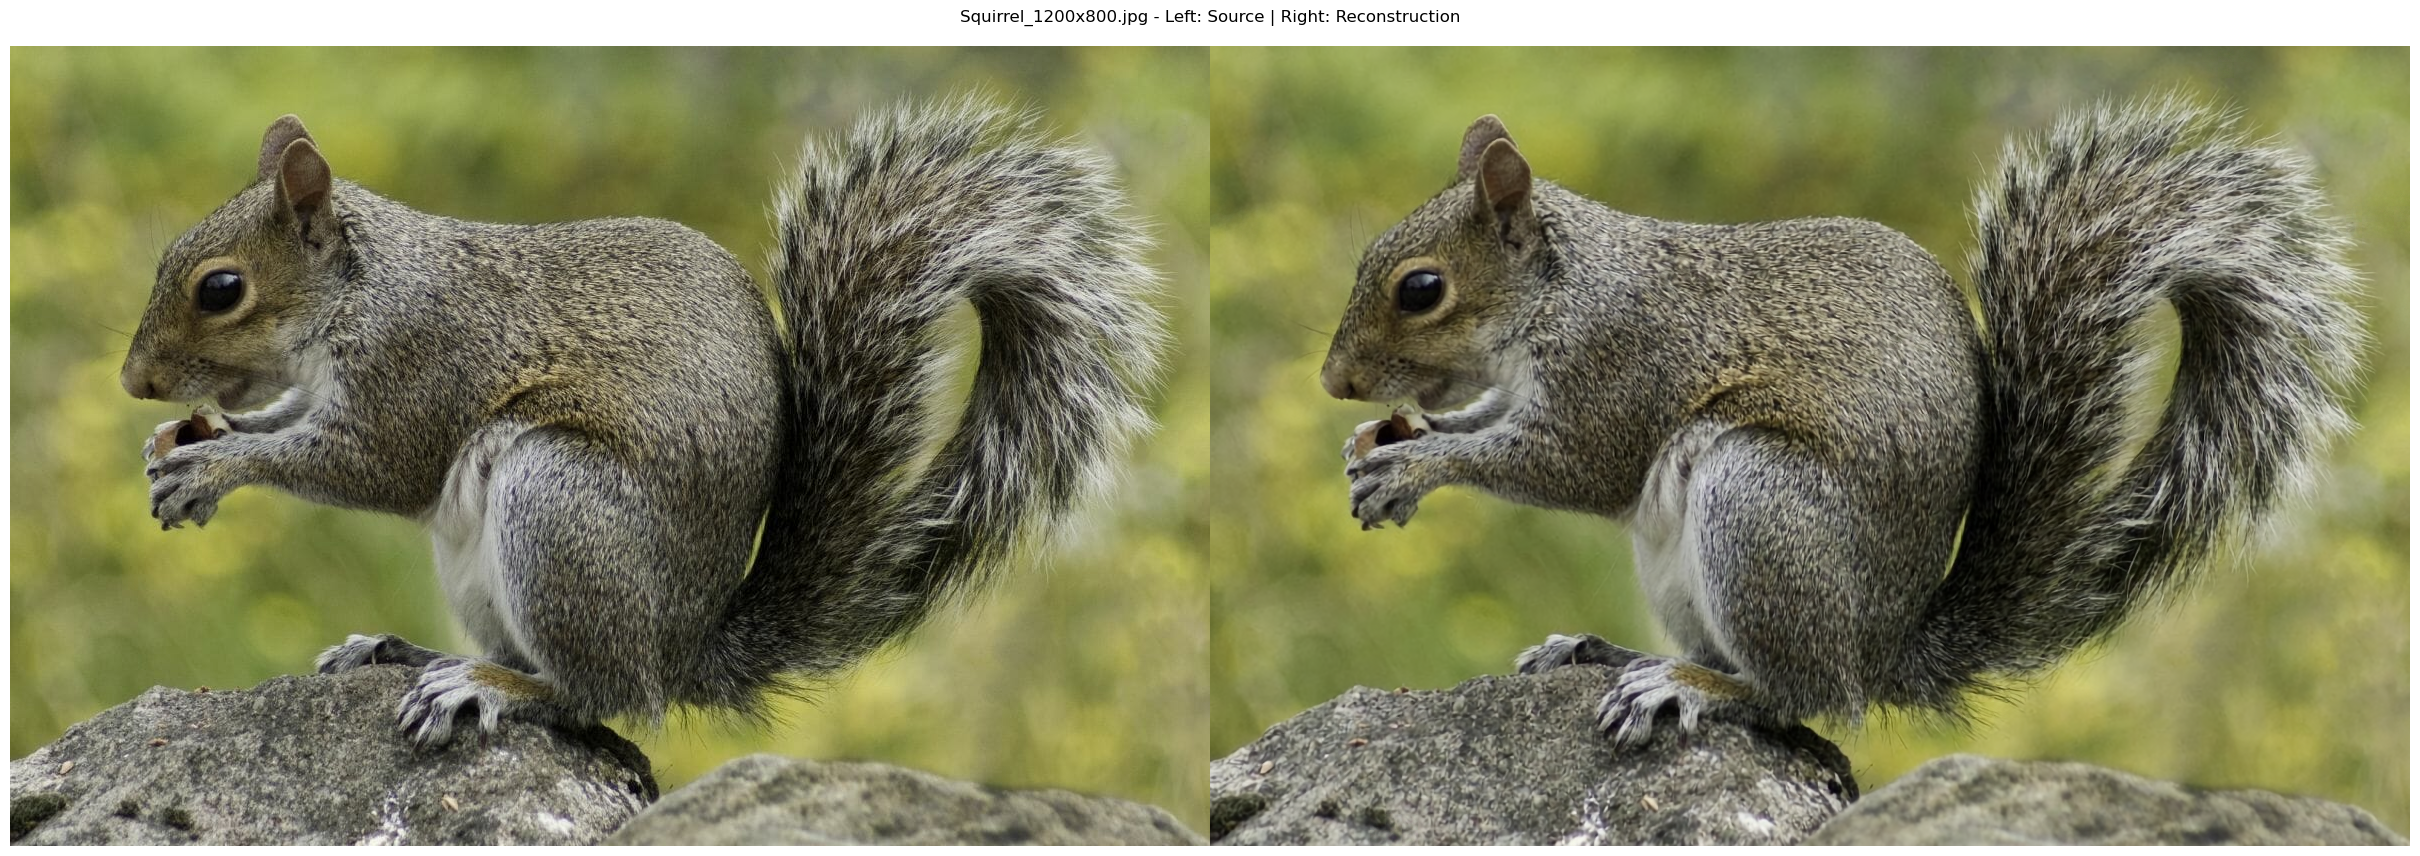


Displaying Squirrel_600x400.jpg...


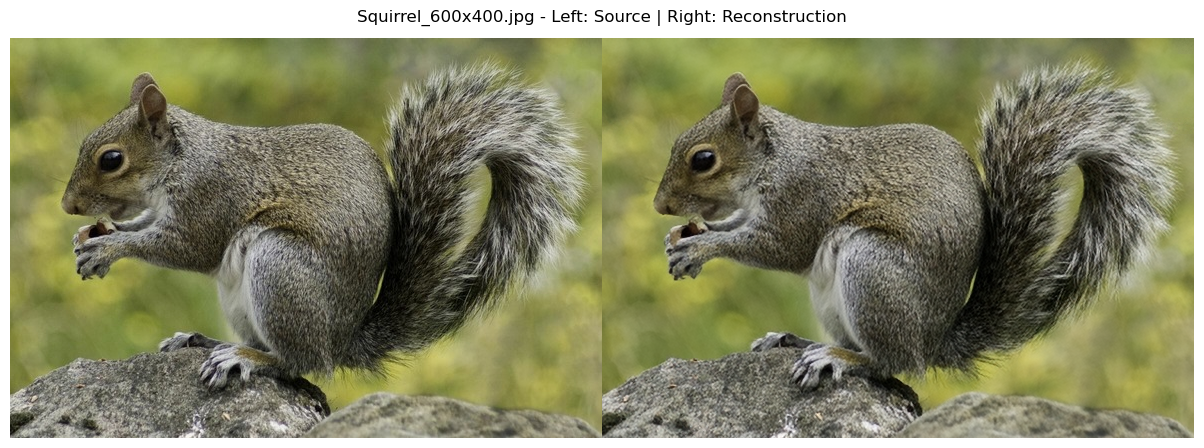


Displaying Squirrel_300x200.jpg...


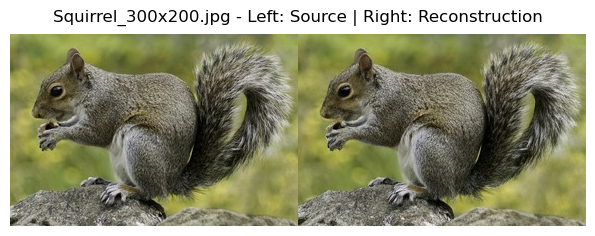

In [2]:
# Image Reconstruction Examples.
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from PIL import Image

from atoken_inference.model.utils import sparse_to_img_list

# All three image URLs
urls = [
    (
        "Squirrel_1200x800.jpg",
        "https://www.dropbox.com/scl/fi/f5ufgb17j6cjaky2fbxzv/Squirrel_1200x800.jpg?rlkey=k6cj1j2cw0osq5akevnc11n8m&st=sm8ulal7&dl=1",
    ),
    (
        "Squirrel_600x400.jpg",
        "https://www.dropbox.com/scl/fi/11ppg61ew1tut8vxlfdrt/Squirrel_600x400.jpg?rlkey=x0c7fmbiusy33mtj8fv94h44c&st=kirf3xah&dl=1",
    ),
    (
        "Squirrel_300x200.jpg",
        "https://www.dropbox.com/scl/fi/el4tccvfilstttonmjo37/Squirrel_300x200.jpg?rlkey=5lmh3sx7wyuoqvq687mtxgmy8&st=qv1zf31g&dl=1",
    ),
]

# Download and prepare all images
img_tensors = []
filenames = []

for filename, url in urls:
    print(f"Downloading {filename}...")
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content)).convert("RGB")
        print(f"Downloaded successfully! Size: {img.size}")

        # Convert to tensor and normalize
        img_tensor = torch.from_numpy(np.array(img))  # (H, W, C)
        img_tensor = (img_tensor.float() / 255.0) * 2 - 1  # normalize to [-1, 1]

        img_tensors.append(img_tensor)
        filenames.append(filename)
    else:
        print(f"Error downloading: {response.status_code}")

# Encode all images together
print(f"\nEncoding {len(img_tensors)} images together...")
img_sparse = wrapper.image_video_to_sparse_tensor(img_tensors)
task_types = ["image"] * len(img_tensors)  # One task type per image
kwargs = {"task_types": task_types}
rec, image_feat, x_no_proj = wrapper.inference(img_sparse, **kwargs)

img_list = sparse_to_img_list(img_sparse.cpu(), [4, 16, 16], task_types=task_types)
rec_list = sparse_to_img_list(rec.cpu(), [4, 16, 16], task_types=task_types)

# Display all results at native resolution
for idx, (filename, img, rec) in enumerate(zip(filenames, img_list, rec_list)):
    print(f"\nDisplaying {filename}...")
    comparison = torch.cat((img, rec), dim=-1)

    # Convert from [-1, 1] to [0, 1] for display
    comparison = (comparison + 1) / 2
    comparison = comparison.squeeze(0)  # Remove batch dimension: (C, H, W)
    comparison = comparison.permute(1, 2, 0)  # Permute to (H, W, C)
    comparison = comparison.cpu().float().numpy().clip(0, 1)

    # Calculate figure size based on image dimensions for native resolution
    dpi = 100  # Standard DPI
    height, width = comparison.shape[:2]
    figsize = (width / dpi, height / dpi)

    # Display using matplotlib at native resolution
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(comparison, aspect="auto")
    plt.title(f"{filename} - Left: Source | Right: Reconstruction", y=1.02)
    plt.show()

#### Image Understanding

##### Let's use SigLIP2 to get a reference first:

In [3]:
# Image understanding using SigLiP2

from urllib.request import urlopen

import torch
from open_clip import (  # works on open-clip-torch >= 2.31.0, timm >= 1.0.15
    create_model_from_pretrained,
    get_tokenizer,
)
from PIL import Image

model, preprocess = create_model_from_pretrained("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")
tokenizer = get_tokenizer("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")


labels_list = ["a dog", "a cat", "a donut", "a squirrel"]
text = tokenizer(labels_list, context_length=model.context_length)

image = Image.open(
    urlopen(
        "https://www.dropbox.com/scl/fi/f5ufgb17j6cjaky2fbxzv/Squirrel_1200x800.jpg?rlkey=k6cj1j2cw0osq5akevnc11n8m&st=sm8ulal7&dl=1"
    )
)
image = preprocess(image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features_siglip2 = model.encode_image(image, normalize=True)
    text_features_siglip2 = model.encode_text(text, normalize=True)
    text_probs_siglip2 = torch.sigmoid(
        image_features_siglip2 @ text_features_siglip2.T * model.logit_scale.exp()
        + model.logit_bias
    )

zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs_siglip2[0]]))
print("Label probabilities for SigLIP2-SO400M: ", zipped_list)

Label probabilities for SigLIP2-SO400M:  [('a dog', 0.0), ('a cat', 0.0), ('a donut', 0.0), ('a squirrel', 53.400000000000006)]


##### For *AToken*, you can use `x_no_proj` for image understanding tasks (such as MLLM). To compute the zero-shot classification, we can just reuse the text embedding to compute the similarity score. 

In [4]:
# Image understanding using AToken

text_probs_atoken = torch.sigmoid(
    image_feat.cpu().float() @ text_features_siglip2.T * wrapper.model.logit_scale.exp().cpu()
    + wrapper.model.logit_bias.cpu()
)
zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs_atoken[0]]))
print("Label probabilities for AToken: ", zipped_list)

Label probabilities for AToken:  [('a dog', 0.0), ('a cat', 0.0), ('a donut', 0.0), ('a squirrel', 97.1)]


#### Video Reconstruction

In [5]:
# Video Reconstruction Examples.

import tempfile

import requests
import torch
from IPython.display import Video, display

from atoken_inference.model.data_utils import decode_video_decord, save_video

# Dropbox URL - change dl=0 to dl=1 for direct download
url = "https://www.dropbox.com/scl/fi/aqu2iwh50wj7gqk4sseon/bird_720p.mp4?rlkey=ttne6gxmtodkanm9rygtsx1so&st=uk4auagl&dl=1"

# Download the video from Dropbox
print("Downloading video from Dropbox...")
response = requests.get(url)
if response.status_code == 200:
    video_byte = response.content
    print(f"Video downloaded successfully! Size: {len(video_byte)} bytes")
else:
    print(f"Error downloading: {response.status_code}")

# Decode the video
video, _, _ = decode_video_decord(
    is_training=False,
    data=video_byte,
    num_to_select=-1,
    min_stride=1,
)
video = (video.float() / 255.0) * 2 - 1  # normalize to [-1, 1]

# Process the video
video_sparse = wrapper.image_video_to_sparse_tensor([video])
task_types = ["video"]
kwargs = {"task_types": task_types}
rec, image_feat, x_no_proj = wrapper.inference(video_sparse, **kwargs)

video_list = sparse_to_img_list(video_sparse.cpu(), [4, 16, 16], task_types=task_types)
rec_list = sparse_to_img_list(rec.cpu(), [4, 16, 16], task_types=task_types)

# Display the results
for video, rec in zip(video_list, rec_list):
    # Ensure they are tensors
    if isinstance(video, np.ndarray):
        video = torch.from_numpy(video)
    if isinstance(rec, np.ndarray):
        rec = torch.from_numpy(rec)

    # Concatenate for comparison
    comparison = torch.cat((video, rec), dim=-1)

    # Save to temporary file and display
    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as tmp:
        save_video(comparison, tmp.name)
        print("Displaying video comparison...")
        display(Video(tmp.name, embed=True, width=1000))

Video downloaded successfully! Size: 675828 bytes
Saved video with 88 frames to /mnt/tmp/tmp22a29_p8.mp4
Displaying video comparison...


#### Video Understanding

For video understanding, we sample the frame @ 1 fps. So we need to update the preprocessor for the image. 

In [6]:
from atoken_inference.model.data_utils import decode_video_decord, save_video

# Turtle
url = "https://www.dropbox.com/scl/fi/1cw5oh8nxrds6pse5q6f4/turtle_1024.mp4?rlkey=434rclds4k842c5okgxjlmt6o&st=5ufyyovm&dl=1"

response = requests.get(url)

if response.status_code == 200:
    video_byte = response.content
    print(f"Video downloaded successfully! Size: {len(video_byte)} bytes")
else:
    print(f"Error downloading: {response.status_code}")

# Decode the video
video, _, _ = decode_video_decord(
    is_training=False,
    data=video_byte,
    num_to_select=10,
    min_stride=1,
)

video = (video.float() / 255.0) * 2 - 1  # normalize to [-1, 1]

# Process the video
video_sparse = wrapper.video_to_padded_sparse_tensor([video])

task_types = ["video"]
kwargs = {"task_types": task_types}
rec, image_feat, x_no_proj = wrapper.inference(video_sparse, **kwargs)

Video downloaded successfully! Size: 3489182 bytes


In [7]:
from urllib.request import urlopen

import torch
from open_clip import (  # works on open-clip-torch >= 2.31.0, timm >= 1.0.15
    create_model_from_pretrained,
    get_tokenizer,
)
from PIL import Image

model, preprocess = create_model_from_pretrained("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")
tokenizer = get_tokenizer("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")

labels_list = ["a dog", "a cat", "a turtle", "a squirrel", "a crab"]
text = tokenizer(labels_list, context_length=model.context_length)

with torch.no_grad(), torch.cuda.amp.autocast():
    text_features_siglip2 = model.encode_text(text, normalize=True)

text_probs_atoken = torch.sigmoid(
    image_feat.cpu().float() @ text_features_siglip2.T * wrapper.model.logit_scale.exp().cpu()
    + wrapper.model.logit_bias.cpu()
)
zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs_atoken[0]]))
print("Label probabilities for AToken: ", zipped_list)

Label probabilities for AToken:  [('a dog', 0.0), ('a cat', 0.0), ('a turtle', 70.39999999999999), ('a squirrel', 0.0), ('a crab', 0.0)]


#### 3D Reconstruction

Add somenote why the performance is poor and how should we improve it.

File downloaded successfully! Size: 32143360 bytes
Running 3D inference...
Rendering frames...


Rendering: 150it [00:01, 143.25it/s]


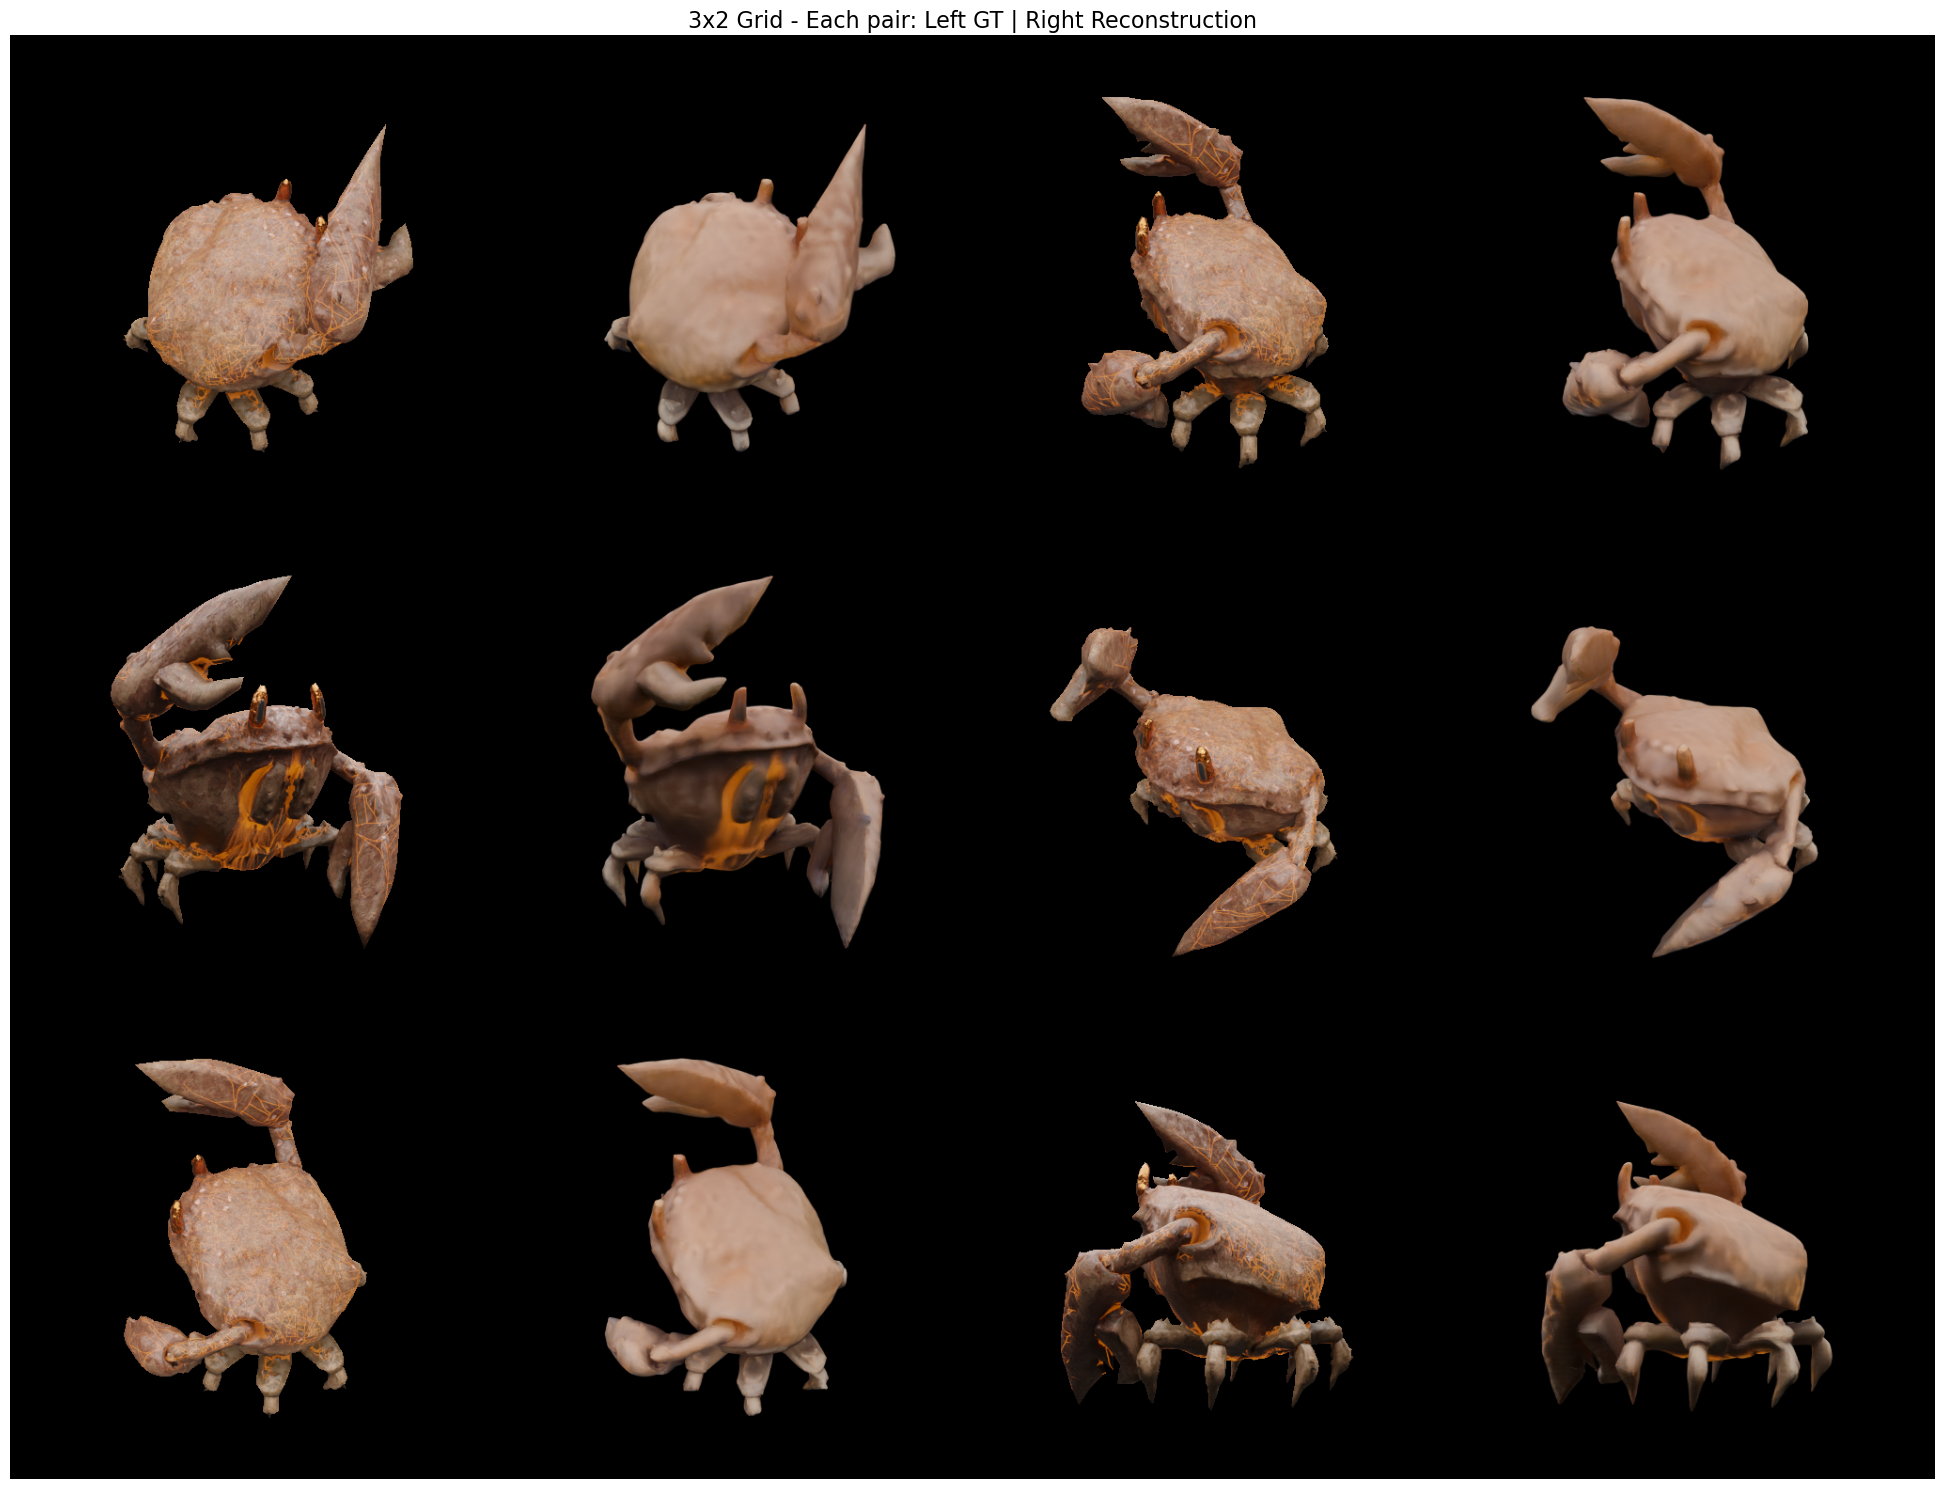

In [8]:
# 3D Reconstruction Examples

import io
import random
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from PIL import Image

from atoken_inference.model.gs.utils import render_utils

model_path = "checkpoints/atoken-soc.pt"
config_path = "configs/atoken-soc.yaml"

gs_model_path = "checkpoints/3d_decode_gs.pt"
gs_config_path = "configs/3d_decode_gs.yaml"

# Download .tar file from Dropbox - change dl=0 to dl=1
url = "https://www.dropbox.com/scl/fi/itbd2biqn7pa7ycvk9cgu/crab_000.tar?rlkey=5nvr5t554mqyxqdy9435mvw20&st=slxjq6iq&dl=1"

print("Downloading .tar file from Dropbox...")
response = requests.get(url)
if response.status_code == 200:
    tar_bytes = io.BytesIO(response.content)
    print(f"File downloaded successfully! Size: {len(response.content)} bytes")
else:
    print(f"Error downloading: {response.status_code}")

# Extract data from tar file
data_name = "crab_000"  # Extracted from the filename
with tarfile.open(fileobj=tar_bytes, mode="r") as tar:
    coords = np.load(io.BytesIO(tar.extractfile(f"{data_name}.coords.npy").read()))
    feats = np.load(io.BytesIO(tar.extractfile(f"{data_name}.feats.npy").read()))
    extrinsics = torch.tensor(
        np.load(io.BytesIO(tar.extractfile(f"{data_name}.w2c.npy").read()))
    ).cuda()
    intrinsics = torch.tensor(
        np.load(io.BytesIO(tar.extractfile(f"{data_name}.intrinsics.npy").read()))
    ).cuda()

wrapper = (
    ATokenWrapper(config_path, model_path, gs_config_path, gs_model_path).cuda().to(torch.bfloat16)
)

print("Running 3D inference...")
gaussians, image_feat, x_no_proj = wrapper.inference_3d(feats, coords)

print("Rendering frames...")
all_frames = render_utils.render_frames(
    gaussians[0],
    extrinsics,
    intrinsics,
    {"resolution": 512, "bg_color": (0, 0, 0)},
)

# Load ground truth images
all_gt = []
tar_bytes.seek(0)  # Reset file pointer
for i in range(len(all_frames["color"])):
    with tarfile.open(fileobj=tar_bytes, mode="r") as tar:
        gt = np.array(Image.open(io.BytesIO(tar.extractfile(f"{data_name}.{i:03d}.webp").read())))
    gt = gt[:, :, :3] * (gt[:, :, 3:4] / 255.0 > 0.5)
    gt = torch.tensor(gt).permute(2, 0, 1).float()
    all_gt.append(gt)
    tar_bytes.seek(0)  # Reset for next iteration

all_gt = torch.stack(all_gt, dim=0).cuda()
all_pred = torch.stack([torch.tensor(i) for i in all_frames["color"]], dim=0).cuda()
all_pred = all_pred.permute(0, 3, 1, 2).float()

# Random pick 6 views
num_samples = 6
indices = random.sample(range(all_pred.shape[0]), num_samples)

# Gather the selected views
selected_gt = all_gt[indices]  # [6, 3, 512, 512]
selected_pred = all_pred[indices]  # [6, 3, 512, 512]

# Normalize to [0, 1]
selected_gt = selected_gt / 255.0
selected_pred = selected_pred / 255.0

# Create 3x2 grid: 3 rows, 2 columns
# Each cell shows GT | Pred side by side
rows = []
for i in range(3):  # 3 rows
    # Get two comparison pairs for this row
    idx1 = i * 2
    idx2 = i * 2 + 1

    # Create comparison for first item (GT | Pred)
    comparison1 = torch.cat([selected_gt[idx1], selected_pred[idx1]], dim=-1)
    # Create comparison for second item (GT | Pred)
    comparison2 = torch.cat([selected_gt[idx2], selected_pred[idx2]], dim=-1)

    # Concatenate the two comparisons horizontally
    row = torch.cat([comparison1, comparison2], dim=-1)
    rows.append(row)

# Stack all rows vertically
grid = torch.cat(rows, dim=-2)

# Convert to numpy for display
grid_np = grid.cpu().permute(1, 2, 0).numpy().clip(0, 1)

# Display in Jupyter notebook
plt.figure(figsize=(20, 15))
plt.imshow(grid_np)
plt.axis("off")
plt.title("3x2 Grid - Each pair: Left GT | Right Reconstruction", fontsize=16)
plt.tight_layout()
plt.show()

#### 3D Understanding

In [9]:
from urllib.request import urlopen

import torch
from open_clip import (  # works on open-clip-torch >= 2.31.0, timm >= 1.0.15
    create_model_from_pretrained,
    get_tokenizer,
)
from PIL import Image

model, preprocess = create_model_from_pretrained("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")
tokenizer = get_tokenizer("hf-hub:timm/ViT-SO400M-16-SigLIP2-384")


labels_list = ["a dog", "a cat", "a donut", "a squirrel", "a crab"]
text = tokenizer(labels_list, context_length=model.context_length)

with torch.no_grad(), torch.cuda.amp.autocast():
    text_features_siglip2 = model.encode_text(text, normalize=True)

text_probs_atoken = torch.sigmoid(
    image_feat.cpu().float() @ text_features_siglip2.T * wrapper.model.logit_scale.exp().cpu()
    + wrapper.model.logit_bias.cpu()
)
zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs_atoken[0]]))
print("Label probabilities for AToken: ", zipped_list)

Label probabilities for AToken:  [('a dog', 0.0), ('a cat', 0.0), ('a donut', 0.0), ('a squirrel', 0.0), ('a crab', 54.300000000000004)]
